In [1]:
# Import libraries
import os
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN, LeakyReLU
from keras import backend as K
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set GPU device
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

## fix random seed for reproducibility
np.random.seed(7)

# processed_data_dir = os.path.join("", "Cryptocurrency data/Processed data/")
# os.listdir(processed_data_dir)

Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1, target = 0):
    """
    Function to convert series from dataset to supervised learning problem
    """
    data_x, data_y = [], []

    for i in range(len(dataset) - look_back):

        # Create sequence of length equal to look_back
        x = dataset[i:(i + look_back), :]
        data_x.append(x)
        
        # Take just the return for the target
        
        data_y.append(dataset[i + look_back, target])

    return np.array(data_x), np.array(data_y)

In [3]:
data = pd.read_csv("BTC_processed.csv")


# data['signal'] = (data['buy_signal'] - data['sell_signal'] + data['hold_signal'])
# data = data.drop(['MFI'], axis = 1)
# data = data.drop(['hold_signal', 'buy_signal', 'sell_signal'], axis = 1)
data = data.drop(['hold_signal', 'buy_signal', 'sell_signal', 'MFI'], axis = 1)

data['time'] = pd.to_datetime(data['time'])
data = data.set_index('time', drop = True)
data = data[~data.index.duplicated(keep='first')]
data['return'] = data['close'].pct_change()
data['return'].head()

data_cummin = data.cummin()
data_cummax = data.cummax()
# scale
offset = 2
data = ((data - data_cummin) /(data_cummax - data_cummin))[offset:]
data.head()

,close,high,low,open,volumefrom,volumeto,12EMA,50EMA,minusDI,plusDI,MACD,MACDsignal,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,return
time,,,,,,,,,,,,,,,,,,,,
2013-02-22,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.000000,1.000000,1.000000,1.0,1.000000,0.000000,1.000000,1.0,1.0,0.190989,0.0,1.000000
2013-02-23,0.25,0.573427,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,0.761243,1.0,0.000000,0.000000,0.080470,1.0,1.0,1.000000,1.0,0.000000
2013-02-24,0.40,0.370629,0.718563,0.457831,0.000000,0.000000,1.0,1.0,0.784454,0.000000,0.346358,1.0,0.044650,0.586462,0.000000,1.0,1.0,0.735067,1.0,0.564855
2013-02-25,1.00,0.370629,0.928144,0.566265,0.052164,0.059797,1.0,1.0,0.635689,0.000000,0.094035,1.0,0.296876,0.594748,0.000000,1.0,1.0,0.234668,1.0,1.000000
2013-02-26,1.00,1.000000,1.000000,1.000000,0.387254,0.440402,1.0,1.0,0.372884,0.595563,0.105779,1.0,0.615785,0.534859,0.326895,1.0,1.0,0.300596,1.0,1.000000


In [4]:
features = data.copy()
features_np = features.to_numpy()

In [5]:
features

,close,high,low,open,volumefrom,volumeto,12EMA,50EMA,minusDI,plusDI,MACD,MACDsignal,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,return
time,,,,,,,,,,,,,,,,,,,,
2013-02-22,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.190989,0.000000,1.000000
2013-02-23,0.250000,0.573427,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.761243,1.000000,0.000000,0.000000,0.080470,1.000000,1.000000,1.000000,1.000000,0.000000
2013-02-24,0.400000,0.370629,0.718563,0.457831,0.000000,0.000000,1.000000,1.000000,0.784454,0.000000,0.346358,1.000000,0.044650,0.586462,0.000000,1.000000,1.000000,0.735067,1.000000,0.564855
2013-02-25,1.000000,0.370629,0.928144,0.566265,0.052164,0.059797,1.000000,1.000000,0.635689,0.000000,0.094035,1.000000,0.296876,0.594748,0.000000,1.000000,1.000000,0.234668,1.000000,1.000000
2013-02-26,1.000000,1.000000,1.000000,1.000000,0.387254,0.440402,1.000000,1.000000,0.372884,0.595563,0.105779,1.000000,0.615785,0.534859,0.326895,1.000000,1.000000,0.300596,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-23,0.335159,0.331877,0.303139,0.300185,0.187586,0.106910,0.368040,0.562373,0.410587,0.241179,0.171208,0.113322,0.404444,0.878099,0.757903,0.380314,0.289233,0.395518,0.992850,0.174584
2020-03-24,0.348809,0.344121,0.340686,0.335148,0.183142,0.112118,0.372908,0.559695,0.388791,0.268940,0.195846,0.124056,0.437356,0.917879,0.779514,0.363511,0.301939,0.383978,1.000000,0.155464
2020-03-25,0.345031,0.350310,0.344765,0.348796,0.147421,0.090634,0.376362,0.556912,0.365259,0.273079,0.215565,0.137070,0.429094,0.975358,0.845058,0.340630,0.322062,0.374990,0.998511,0.142439


In [6]:
# Convert series to supervised learning problem
look_back = 60
target = features.shape[1]-1 # close
print(target)

19


In [7]:
X, y = create_dataset(features_np, look_back, target)

In [8]:
data.iloc[int(X.shape[0] * 0.7 ):]

,close,high,low,open,volumefrom,volumeto,12EMA,50EMA,minusDI,plusDI,MACD,MACDsignal,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,return
time,,,,,,,,,,,,,,,,,,,,
2017-12-29,0.743582,0.760049,0.743639,0.743847,0.207136,0.277539,0.894093,1.000000,0.423908,0.245499,0.250614,0.478210,0.448628,0.750332,0.670616,0.969410,0.831302,0.971607,0.976790,0.145068
2017-12-30,0.647234,0.727371,0.637406,0.743521,0.317620,0.382210,0.870612,0.999190,0.523687,0.214081,0.162351,0.416507,0.357403,0.648290,0.612488,0.938842,0.807136,0.995096,0.941541,0.112360
2017-12-31,0.715514,0.716301,0.658628,0.647246,0.193841,0.238880,0.862775,1.000000,0.479234,0.192842,0.130436,0.360055,0.431112,0.678695,0.590800,0.895636,0.816815,0.993963,0.965183,0.171885
2018-01-01,0.694520,0.700158,0.686307,0.715481,0.136413,0.169291,0.852445,1.000000,0.455633,0.181565,0.092945,0.306566,0.411822,0.704168,0.570145,0.840774,0.839973,0.961729,0.967672,0.137745
2018-01-02,0.762301,0.769944,0.689324,0.694483,0.240107,0.313276,0.855646,1.000000,0.405552,0.256712,0.101321,0.265635,0.479305,0.680878,0.584726,0.804623,0.863896,0.981186,0.996045,0.169888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-23,0.335159,0.331877,0.303139,0.300185,0.187586,0.106910,0.368040,0.562373,0.410587,0.241179,0.171208,0.113322,0.404444,0.878099,0.757903,0.380314,0.289233,0.395518,0.992850,0.174584
2020-03-24,0.348809,0.344121,0.340686,0.335148,0.183142,0.112118,0.372908,0.559695,0.388791,0.268940,0.195846,0.124056,0.437356,0.917879,0.779514,0.363511,0.301939,0.383978,1.000000,0.155464
2020-03-25,0.345031,0.350310,0.344765,0.348796,0.147421,0.090634,0.376362,0.556912,0.365259,0.273079,0.215565,0.137070,0.429094,0.975358,0.845058,0.340630,0.322062,0.374990,0.998511,0.142439


In [10]:
# Declare variables
n_features = X.shape[2]
n_assets = 1 # only BTC

# Split dataset
training_days = int(X.shape[0] * 0.7 )
X_train, X_test = X[:training_days], X[training_days:]
y_train, y_test = y[:training_days], y[training_days:]

# Prepare the 3D input vector for the LSTM
X_train = np.reshape(X_train, (-1, look_back, n_features))
X_test = np.reshape(X_test, (-1, look_back, n_features))

batch_size = 1

# Create the model
model = Sequential()
model.add(LSTM(n_features,
               input_shape=(look_back, n_features),
               batch_size=batch_size,
               stateful=True,
               activity_regularizer=regularizers.l1_l2(),
               recurrent_regularizer=regularizers.l1_l2()))
model.add(Dropout(0.2))
model.add(Dense(n_assets))
# now add a ReLU layer explicitly:
model.add(LeakyReLU(alpha=0.1))

# Compile the LSTM model
model.compile(loss='mse', optimizer='rmsprop')

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 20)                   3280      
_________________________________________________________________
dropout_1 (Dropout)          (1, 20)                   0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    21        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (1, 1)                    0         
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
_________________________________________________________________


In [12]:
## Training and evaluating the model (On-line learning)

# Create empty arrays
y_pred = np.empty((0, n_assets))
y_true = np.empty((0, n_assets))

for j in range(training_days - look_back + 1, X.shape[0]):

    if j == (training_days - look_back + 1):

        # First training days for training
        X_train = X[:j]
        y_train = y[:j]

        # Next day for forecasting
        X_test = X[j].reshape(1, look_back, n_features)

        # Ensure the correct shape for LSTM
        X_test = np.tile(X_test, (batch_size, 1, 1))
        y_test = np.tile(y[j], (batch_size, 1))

        # Training epochs
        epochs = 300
    
    else:

        # Available data to refine network state
        X_train = X_test
        y_train = y_test

        # Ensure the correct shape for LSTM
        X_test = X[j].reshape(1, look_back, n_features)
        X_test = np.tile(X_test, (batch_size, 1, 1))
        y_test = np.tile(y[j], (batch_size, 1))

        # Epochs for updating
        epochs = 20
        
    # Fit the model
    for i in range(epochs):
        model.fit(X_train,
                  y_train,
                  epochs=1,
                  batch_size=batch_size,
                  verbose=0,
                  shuffle=False)
        model.reset_states()
    
    # Evaluate the model
    # Make predictions
    predicted_output = model.predict(X_test, batch_size=batch_size)

    predicted_output = predicted_output[0].reshape(1, n_assets)
    true_output = y_test[0].reshape(1, n_assets)

    # Save current prediction into an array
    y_pred = np.append(y_pred, predicted_output, axis=0)
    y_true = np.append(y_true, true_output, axis=0)

In [13]:
mse = np.mean((y_true - y_pred) ** 2)
print(mse)

0.0001985172698721765


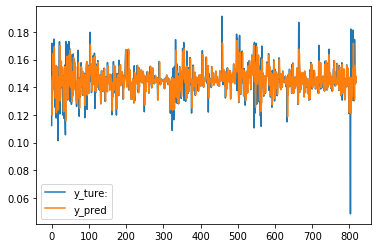

In [14]:
pd.DataFrame({"y_ture:": y_true.flatten(), "y_pred":y_pred.flatten()}).plot()

In [15]:
pred_mul_factor = (data_cummax[training_days + offset + 1:] - data_cummin[training_days + offset + 1:] )['return'].to_numpy()
pred_shift_factor = data_cummin[training_days + offset + 1:]['return'].to_numpy()

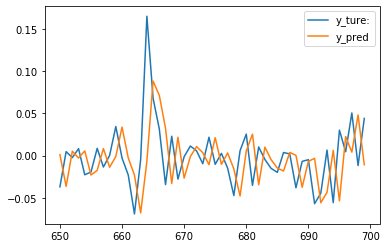

In [16]:
raw_y_true = np.add(np.multiply(y_true.flatten(), pred_mul_factor), pred_shift_factor)
raw_y_pred = np.add(np.multiply(y_pred.flatten(), pred_mul_factor), pred_shift_factor)
pd.DataFrame({"y_ture:": raw_y_true, "y_pred":raw_y_pred})[650:700].plot()

In [17]:
result = pd.DataFrame({"Real": raw_y_true, "LSTM2":raw_y_pred}, index =data.iloc[int(X.shape[0] * 0.7 )+1:].index)
result.to_pickle("result_LSTM2.pk")